This Jupyter notebook implements the segmentation of nuclei in whole-slide images (WSIs) of cancerous tissue slides using the PanNuke dataset. It is designed to work with the PanNuke extension dataset which includes nearly 200,000 nuclei across various cancer types. The notebook contains detailed Pytorch code for applying deep learning models to perform nuanced segmentation tasks that are crucial for advancing computational pathology.

In [1]:
import os
import random
import time
from shutil import copyfile

import cv2
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchmetrics as TM
import torchvision
import torchvision.transforms as T

from PIL import Image
from torch.utils.data import Dataset, DataLoader

import albumentations as A
import matplotlib.pyplot as plt
import segmentation_models_pytorch as smp

In [ ]:
# Predefined transformations for frequent use
Tensor2PILImage = T.ToPILImage()
PILImage2Tensor = T.ToTensor()

In [ ]:
# Classes

CLASSES = ['Background', 'Neoplastic', 'Inflammatory', 'Connective', 'Dead', 'Epithelial']

num_of_classes = len(CLASSES)

CLASS_COLORS = [(0, 0, 0), (255, 0, 0), (255, 0, 255), (0, 255, 0), (0, 0, 255), (255, 255, 0)]

class_weights = [0.1, 1, 1, 1, 1, 1]

imagesize = 256

In [ ]:
def get_device():
    """Return the appropriate device (CUDA or CPU) based on availability."""
    return torch.device("cuda" if torch.cuda.is_available() else "cpu")


def to_device(x):
    """Send the tensor or model to the appropriate device."""
    device = get_device()
    return x.to(device)

print(f"CUDA: {torch.cuda.is_available()}")

CUDA: True


In [ ]:
# Create a nested directory structure
parent_dir =    # Please enter the root directory for your project:

Save_folder_name = "CIS V7T02"
save_path = os.path.join(parent_dir, Save_folder_name)

input_path_1 = os.path.join(parent_dir, 'Part 1', 'Images', 'images.npy')
output_path_1 = os.path.join(parent_dir, 'Part 1', 'Masks', 'masks.npy')
input_path_2 = os.path.join(parent_dir, 'Part 2', 'Images', 'images.npy')
output_path_2 = os.path.join(parent_dir, 'Part 2', 'Masks', 'masks.npy')
input_path_3 = os.path.join(parent_dir, 'Part 3', 'Images', 'images.npy')
output_path_3 = os.path.join(parent_dir, 'Part 3', 'Masks', 'masks.npy')

#load image npy
image_1=np.load(input_path_1,mmap_mode='r')[:1000]
masks_1=np.load(output_path_1,mmap_mode='r')[:1000]

image_2=np.load(input_path_2,mmap_mode='r')[:1000]
masks_2=np.load(output_path_2,mmap_mode='r')[:1000]

image_3=np.load(input_path_3,mmap_mode='r')[:1000]
masks_3=np.load(output_path_3,mmap_mode='r')[:1000]

try:
    os.mkdir(save_path)
except OSError:
    pass


In [ ]:
images = np.concatenate((image_1, image_2, image_3), axis=0)
masks = np.concatenate((masks_1, masks_2, masks_3), axis=0)

#print shape of image npy
print(image_1.shape, image_2.shape, image_3.shape, images.shape)
print(masks_1.shape, masks_2.shape, masks_3.shape, masks.shape)

(1000, 256, 256, 3) (1000, 256, 256, 3) (1000, 256, 256, 3) (3000, 256, 256, 3)
(1000, 256, 256, 6) (1000, 256, 256, 6) (1000, 256, 256, 6) (3000, 256, 256, 6)


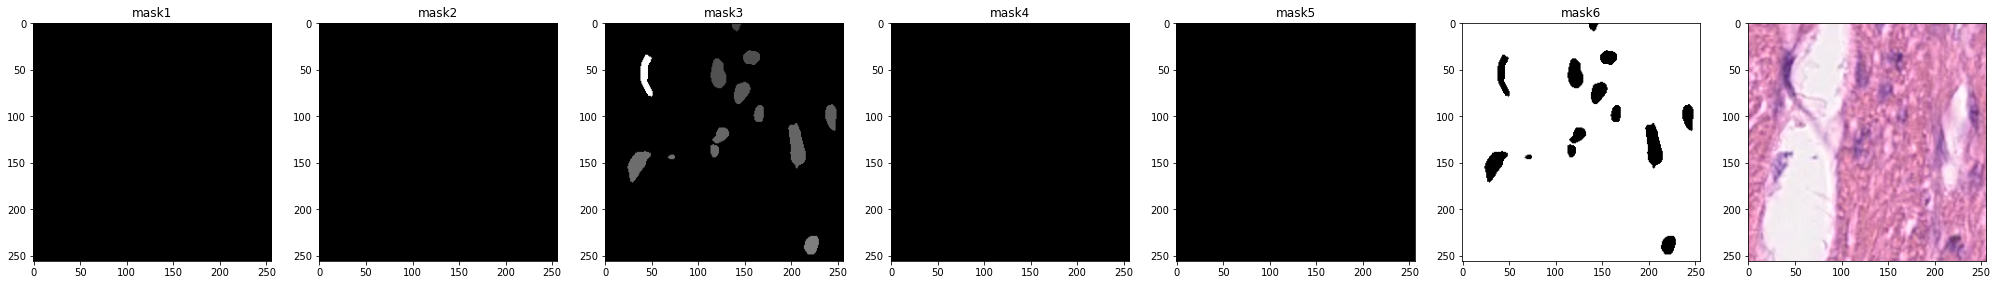

In [ ]:
def Plot_image_sample(ind):
    fig, axes = plt.subplots(nrows=1, ncols=7, figsize=(35, 5))
    axes = axes.flatten()
    for i in range(6):#six data last one is flag, so we only need 0,1,2,3,4
        axes[i].imshow(masks[ind][:,:,i], cmap='gray')
        axes[i].set_title('mask'+str(i+1))
    axes[6]=plt.imshow(images.astype('int32')[ind])

Plot_image_sample(800)

In [ ]:
def delete_no_cells_tiles(images, masks):
    del_ind = []
    for i in range(masks.shape[0]):
        if np.max(masks[i,:,:,:5])==0:
            del_ind.append(i)
    print(del_ind)
    images = np.delete(images, del_ind, 0)
    masks = np.delete(masks, del_ind, 0)
    return images, masks


images, masks = delete_no_cells_tiles(images, masks)

[584, 586, 604, 748, 750, 780, 811, 812, 813, 828, 830, 832, 833, 996, 998, 1544, 1679, 1680, 1724, 1749, 1750, 1752, 1753, 2236, 2546, 2735, 2754, 2762, 2778, 2780, 2784]


In [ ]:
#print shape of image npy
print(image_1.shape, image_2.shape, image_3.shape, images.shape)
print(masks_1.shape, masks_2.shape, masks_3.shape, masks.shape)

(1000, 256, 256, 3) (1000, 256, 256, 3) (1000, 256, 256, 3) (2969, 256, 256, 3)
(1000, 256, 256, 6) (1000, 256, 256, 6) (1000, 256, 256, 6) (2969, 256, 256, 6)


In [ ]:
def vectorize_3d_mask(masks):
    # Verify the shape of the mask_set
    if masks.shape[1:] != (imagesize, imagesize, 6):
        raise ValueError(f"Expected shape for each mask: ({imagesize}, {imagesize}, 6)")

    # Initialize the 2D mask array
    mask_2d = np.zeros(masks.shape[:3], dtype=int)

    # Apply mask channel indices, preferring lower index channels where overlaps occur
    for channel in range(len(CLASSES)-1):
        channel_mask = (masks[..., channel] != 0) & (mask_2d == 0)
        mask_2d[channel_mask] = channel + 1

    return np.expand_dims(mask_2d, axis=-1)

In [ ]:
mask_2d = vectorize_3d_mask(masks)
images = np.uint8(images)

print(mask_2d.shape)
print(images.shape)

(2969, 256, 256, 1)
(2969, 256, 256, 3)


In [ ]:
def get_images(images, masks, fold_num = 1, max_fold = 5):
    """Split images and masks based on the fold."""

    # Calculate the indices for training and validation splits
    num_samples = images.shape[0]
    start_val = int((fold_num - 1) / max_fold * num_samples)
    end_val = int(fold_num / max_fold * num_samples)

    train_images = np.concatenate((images[:start_val], images[end_val:]), axis=0)
    train_masks = np.concatenate((masks[:start_val], masks[end_val:]), axis=0)
    valid_images = images[start_val:end_val]
    valid_masks = masks[start_val:end_val]

    return train_images, train_masks, valid_images, valid_masks

def train_transforms(img_size):
    """Transforms/augmentations for training images and masks."""
    train_image_transform = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.Affine(shear=0.4, mode=4, p=0.3),
        A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=1.0),
        A.ShiftScaleRotate(scale_limit=0.2, rotate_limit=180, shift_limit=0.5, p=1.0),
        A.PadIfNeeded(min_height=img_size, min_width=img_size, always_apply=True),
        A.Blur(blur_limit=10, p=0.2),
        A.Sharpen(alpha = 0.1, p=0.2),
        A.GaussNoise(var_limit=50, p=0.25),
        A.ColorJitter(brightness=0.25, contrast=0.25, saturation=0.1, hue=0.05, p=0.2),
        A.Superpixels(p_replace=0.1, n_segments=200, max_size= 100, p=0.1),
        A.ZoomBlur(max_factor=1.05, p=0.1),
        A.RandomResizedCrop(scale=(0.5, 1.0), size = (imagesize, imagesize), p=0.1),
        A.ElasticTransform(sigma=25, alpha= 0.5, alpha_affine=15, p=0.2),
        # A.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5), p=1.0)
    ])
    return train_image_transform


def valid_transforms(img_size):
    """Transforms/augmentations for validation images and masks."""
    return A.Compose([A.Resize(img_size, img_size, always_apply=True)])



class SegmentationDataset(Dataset):
    def __init__(self, images, masks, tfms):
        self.images = images
        self.masks = masks
        self.tfms = tfms


    def __len__(self):
        return len(self.images)


    def __getitem__(self, idx):
        image = self.images[idx]
        mask = self.masks[idx]


        # Apply transformations
        transformed = self.tfms(image=image, mask=mask)
        image = transformed['image']
        mask = transformed['mask']

        # Convert to tensors
        image = torch.from_numpy(np.transpose(image/255, (2, 0, 1))).float()
        mask = torch.from_numpy(np.transpose(mask, (2, 0, 1))).long()

        return image, mask

In [ ]:
# Define constants for training
classes_to_train = CLASSES
batch_size = 15
fold_num = 1
max_fold = 5

# Load images and masks
train_images, train_masks, valid_images, valid_masks = get_images(images, mask_2d, fold_num = 1, max_fold = 5)

# Set up transformations
train_tfms = train_transforms(imagesize)
valid_tfms = valid_transforms(imagesize)

# Initialize datasets
train_dataset = SegmentationDataset(train_images, train_masks, train_tfms)
valid_dataset = SegmentationDataset(valid_images, valid_masks, valid_tfms)

# Configure data loaders
train_data_loader = DataLoader(train_dataset, batch_size=batch_size, drop_last=False)
valid_data_loader = DataLoader(valid_dataset, batch_size=batch_size, drop_last=False)

# Access a batch of data
(train_data_inputs, train_data_targets) = next(iter(train_data_loader))
(valid_data_inputs, valid_data_targets) = next(iter(valid_data_loader))
print(train_images.shape, train_masks.shape, valid_images.shape, valid_masks.shape)
print(train_data_inputs.shape, train_data_targets.shape, train_data_inputs.dtype, train_data_targets.dtype)

(2376, 256, 256, 3) (2376, 256, 256, 1) (593, 256, 256, 3) (593, 256, 256, 1)
torch.Size([15, 3, 256, 256]) torch.Size([15, 1, 256, 256]) torch.float32 torch.int64


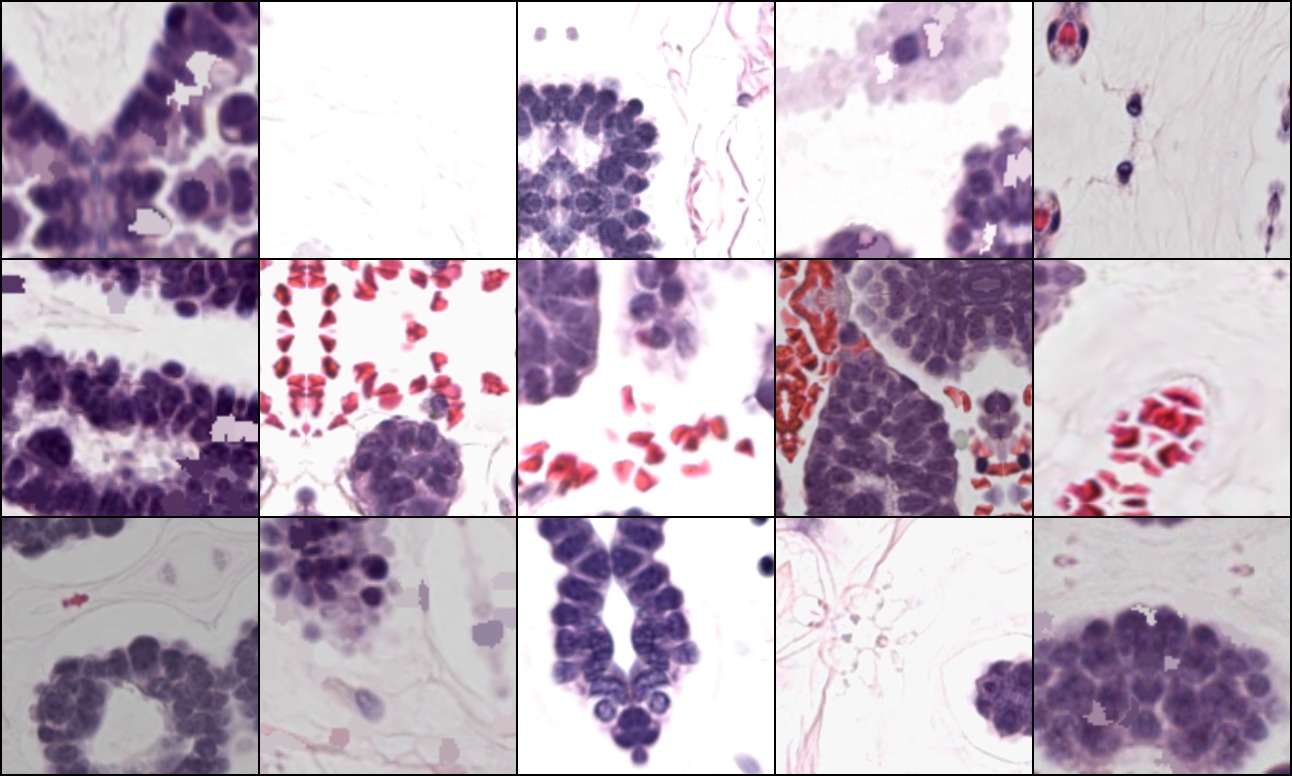

In [ ]:
# Create a grid of input images
data_input_grid = torchvision.utils.make_grid(train_data_inputs, nrow=5)
# Convert the tensor to a PIL Image
Tensor2PILImage(data_input_grid)

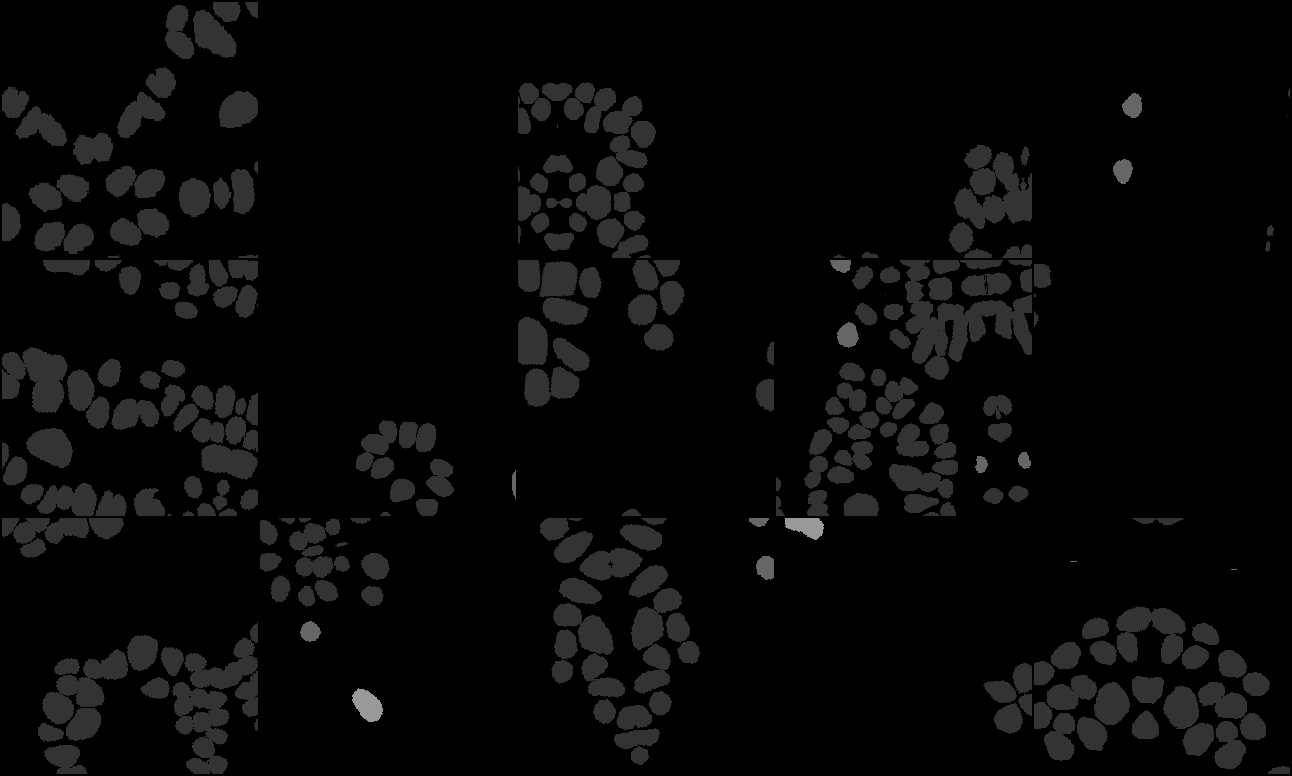

In [ ]:
# Create a grid of output images
data_targets_grid = torchvision.utils.make_grid(train_data_targets / 5.0, nrow=5)
# Convert the tensor to a PIL Image
Tensor2PILImage(data_targets_grid)

In [ ]:
# Initialize the model and move it to the defined device
model = smp.FPN("mit_b5", encoder_weights='imagenet', classes=len(classes_to_train))
to_device(model)

# Perform a forward pass and check the output shape
print(model(to_device(train_data_inputs)).shape)

torch.Size([15, 6, 256, 256])


In [2]:
def plot_metric(x, y, xlabel, ylabel, title, save_path, filename):
    """Helper function to plot and save a metric."""
    plt.figure(figsize=(10, 7), facecolor='white')
    plt.plot(x, color='tab:blue', linestyle='-', label=f'train {ylabel}')
    plt.plot(y, color='tab:red', linestyle='-', label=f'validation {ylabel}')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.savefig(os.path.join(save_path, filename))


def learning_plots(train_acc, val_acc, train_loss, val_loss, train_iou, valid_iou, save_path):
    """Function to save the loss, accuracy, and IoU plots to disk."""

    plot_metric(train_acc, val_acc, 'Epochs', 'accuracy', 'Training vs Validation Accuracy', save_path, 'accuracy.png')

    plot_metric(train_loss, val_loss, 'Epochs', 'loss', 'Training vs Validation Loss', save_path, 'loss.png')

    plot_metric(train_iou, valid_iou, 'Epochs', 'IoU', 'Training vs Validation mIoU', save_path, 'iou.png')


In [3]:
def IoUMetric(pred, gt, num_of_classes, weights=None, softmax=False):
    """Calculate the weighted mean Intersection over Union (IoU)."""
    # Run softmax if input is logits.
    if softmax is True:
        pred = nn.Softmax(dim=1)(pred)

    # One-hot encoding of ground truth
    gt = F.one_hot(gt.squeeze(1), num_classes=num_of_classes).permute(0, 3, 1, 2).float()

    # Computation of intersection and union
    intersection = torch.sum(gt * pred, dim=(2, 3))
    union = torch.sum(pred + gt, dim=(2, 3)) - intersection

    # Apply weights
    if weights is not None:
        intersection = weights * intersection
        union = weights * union


    # Compute IoU avoiding division by zero
    valid = union > 0
    iou = torch.zeros_like(union)
    iou[valid] = intersection[valid] / union[valid]

    # Mean IoU across all valid entries
    return iou[valid].mean()




In [ ]:
def train_model(model, loader, optimizer):
    """Trains the model using a specified data loader and optimizer."""
    to_device(model.train())

    criterion = smp.losses.TverskyLoss(mode='multiclass', classes=num_of_classes, from_logits=True)

    running_loss = 0.0
    running_samples = 0

    for inputs, targets in loader:
        inputs, targets = to_device(inputs), to_device(targets)
        optimizer.zero_grad()
        outputs = model(inputs)

        if use_cel:
            targets = targets.squeeze(dim=1)

        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_samples += inputs.size(0)
        running_loss += loss.item() * inputs.size(0)

    return running_loss / running_samples

In [ ]:
def calculate_metrics(model, loader, use_cel=False):
    """Calculates different metrics during training."""

    criterion = smp.losses.TverskyLoss(mode='multiclass', classes=num_of_classes, from_logits=True)

    to_device(model.eval())
    f1score = to_device(TM.classification.MulticlassF1Score(num_of_classes, average='micro'))
    pixel_metric = to_device(TM.classification.MulticlassAccuracy(num_of_classes, average='micro'))

    f1_scores = []
    pixel_accuracies = []
    iou_accuracies = []
    running_loss = 0.0
    running_samples = 0

    for inputs, targets in loader:
        inputs = to_device(inputs)
        targets = to_device(targets)
        predictions = model(inputs)

        if use_cel:
            targets_cel = targets.squeeze(dim=1)
        else:
            targets_cel = targets

        loss = criterion(predictions, targets_cel)
        running_samples += inputs.size(0)
        running_loss += loss.item() * inputs.size(0)

        pred_probabilities = nn.Softmax(dim=1)(predictions)
        pred_labels = predictions.argmax(dim=1)

        pred_labels = pred_labels.unsqueeze(1)
        pred_mask = pred_labels.to(torch.float)

        f1_score = f1score(pred_mask, targets)
        pixel_accuracy = pixel_metric(pred_labels, targets)
        iou = IoUMetric(pred_probabilities, targets, num_of_classes=num_of_classes, weights=to_device(torch.tensor(class_weights)))

        f1_scores.append(f1_score.item())
        pixel_accuracies.append(pixel_accuracy.item())
        iou_accuracies.append(iou.item())

    f1_score_tensor = torch.FloatTensor(f1_scores)
    accuracy_tensor = torch.FloatTensor(pixel_accuracies)
    iou_tensor = torch.FloatTensor(iou_accuracies)

    return running_loss/running_samples, accuracy_tensor.mean().item(), iou_tensor.mean().item(), f1_score_tensor.mean().item()

In [ ]:
def train_loop(model, train_loader, valid_loader, epochs, optimizer, scheduler, save_path):
    """Trains the model over specified epochs, evaluates performance metrics, and saves the trained model."""

    train_loss_list, train_acc_list, train_iou_list, train_f1_list = [], [], [], []
    val_loss_list, val_acc_list, val_iou_list, val_f1_list = [], [], [], []
    start_time = time.time()
    for epoch in range(1, epochs + 1):
        loss = train_model(model, train_loader, optimizer)
        with torch.inference_mode():
            train_loss, train_acc, train_iou, train_f1 = calculate_metrics(model, train_loader)
            val_loss, val_acc, val_iou, val_f1 = calculate_metrics(model, valid_loader)

        train_loss_list.append(train_loss)
        train_acc_list.append(train_acc)
        train_iou_list.append(train_iou)
        train_f1_list.append(train_f1)
        val_loss_list.append(val_loss)
        val_acc_list.append(val_acc)
        val_iou_list.append(val_iou)
        val_f1_list.append(val_f1)

        end_time = time.time()
        print(f"Epoch: {epoch:04d}, E_time: {int(end_time - start_time):04d}s, LR: {optimizer.param_groups[0]['lr']:.5f}, Training: (Loss: {train_loss:.4f}, Acc: {train_acc:.4f}, F1: {train_f1:.4f}, IoU: {train_iou:.4f}), " +
        f"Valication: (Loss: {val_loss:.4f}, Acc: {val_acc:.4f}, F1: {val_f1:.4f}, IoU: {val_iou:.4f})")

        start_time = end_time

        if scheduler is not None:
            scheduler.step()


    torch.save(model.state_dict(), os.path.join(save_path, f"Trained_model.pth"))
    learning_plots(train_acc_list, val_acc_list, train_loss_list, val_loss_list, train_iou_list, val_iou_list, save_path)


Epoch: 0001, E_time: 0204s, LR: 0.00100, Training: (Loss: 0.4544, Acc: 0.8245, F1: 0.8245, IoU: 0.2006), Valication: (Loss: 0.4581, Acc: 0.8358, F1: 0.8358, IoU: 0.2143)
Epoch: 0002, E_time: 0198s, LR: 0.00100, Training: (Loss: 0.4334, Acc: 0.8265, F1: 0.8265, IoU: 0.2166), Valication: (Loss: 0.4316, Acc: 0.8346, F1: 0.8346, IoU: 0.2378)
Epoch: 0003, E_time: 0196s, LR: 0.00100, Training: (Loss: 0.4317, Acc: 0.8435, F1: 0.8435, IoU: 0.2085), Valication: (Loss: 0.4501, Acc: 0.8436, F1: 0.8436, IoU: 0.2171)
Epoch: 0004, E_time: 0200s, LR: 0.00100, Training: (Loss: 0.4314, Acc: 0.8481, F1: 0.8481, IoU: 0.2137), Valication: (Loss: 0.4348, Acc: 0.8515, F1: 0.8515, IoU: 0.2322)
Epoch: 0005, E_time: 0198s, LR: 0.00100, Training: (Loss: 0.4107, Acc: 0.8518, F1: 0.8518, IoU: 0.2268), Valication: (Loss: 0.4086, Acc: 0.8582, F1: 0.8582, IoU: 0.2531)
Epoch: 0006, E_time: 0198s, LR: 0.00100, Training: (Loss: 0.3951, Acc: 0.8511, F1: 0.8511, IoU: 0.2309), Valication: (Loss: 0.3962, Acc: 0.8595, F1: 0

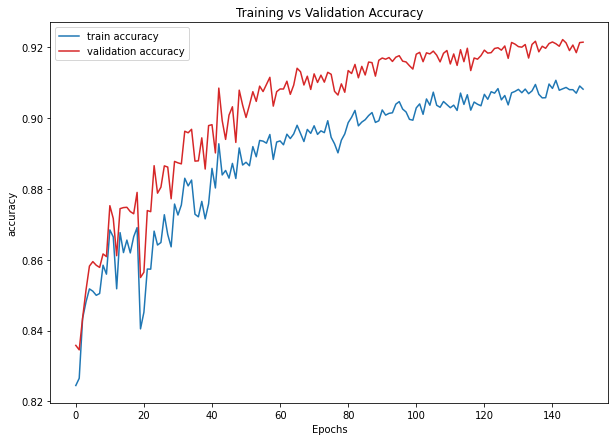

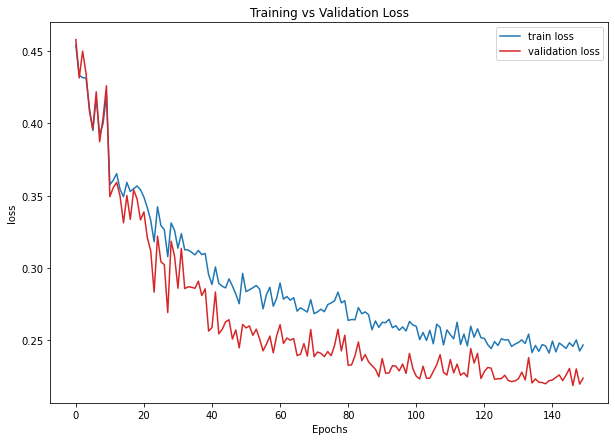

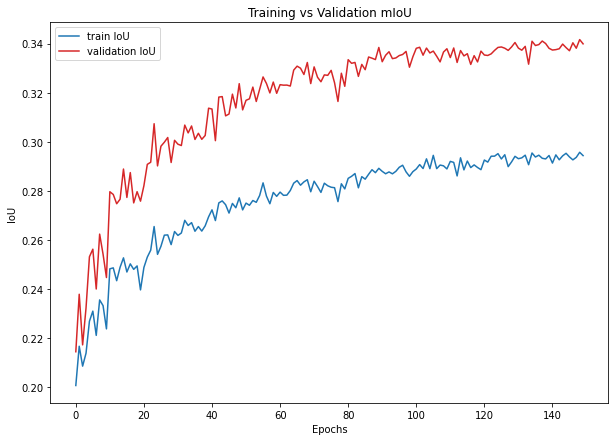

In [ ]:
# Set random seeds and make CUDA operations deterministic for reproducible results across multiple runs
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True

# Optimizer and Learning Rate Scheduler.
to_device(model)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.85,0.85))
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.7)
epochs = 150

train_loop(model, train_data_loader, valid_data_loader, epochs, optimizer, scheduler, save_path)

In [ ]:
def inv_segmentation_map(outputs):
    """Converts model output tensors into a segmentation map."""
    labels = torch.argmax(outputs.squeeze(), dim=0).detach().cpu().numpy()
    class_colors = np.array(CLASS_COLORS)

    # Create the segmentation map by indexing directly into class_colors
    segmentation_map = class_colors[labels]

    return segmentation_map

def make_predictions(image_sample, mask_sample):
    """Processes OCTA images to predict segmentation maps, evaluate model performance metrics, and visualize the results."""

    image_sample = torch.from_numpy(np.transpose(image_sample/255, (2, 0, 1))).float().unsqueeze(0)
    mask_sample_map = torch.nn.functional.one_hot(torch.tensor(mask_sample, dtype=torch.long), num_classes=6).permute(2, 3, 0, 1)

    # Model predictions and evaluations
    with torch.inference_mode():
        pred = model(to_device(image_sample))
    impred = nn.Softmax(dim=1)(pred)

    tp, fp, fn, tn = smp.metrics.get_stats(impred, to_device(mask_sample_map), mode='multilabel', threshold=0.5)
    iou_score_smp = smp.metrics.iou_score(tp, fp, fn, tn, reduction="macro", zero_division=1).item()
    iou_score_smp_N = smp.metrics.iou_score(tp, fp, fn, tn, reduction=None, zero_division=1)
    f1_score_smp = smp.metrics.f1_score(tp, fp, fn, tn, reduction="macro").item()
    accuracy_smp = smp.metrics.accuracy(tp, fp, fn, tn, reduction="macro").item()
    accuracy_smp_N = smp.metrics.accuracy(tp, fp, fn, tn, reduction=None)

    iou_perclass_smp = iou_score_smp_N.tolist()[0]
    accuracy_perclass_smp = accuracy_smp_N.tolist()[0]

    mask_inv = inv_segmentation_map(mask_sample_map)
    impredinv = inv_segmentation_map(impred)

    # print('meanIOU (smp) = ', iou_score_smp)
    # print('IOU coef per class (smp) = ', iou_perclass_smp)

    plt.figure(figsize=(35, 35)).patch.set_facecolor('white')
    display_list = [Tensor2PILImage(image_sample.squeeze()), mask_inv, impredinv]
    titles=['Input', 'Ground Truth', 'Predicted\nAcc= '+str(np.around(accuracy_smp,4))+', meanIOU= '+str(np.around(iou_score_smp,4))+', IOU coef per class = '+str(np.around(iou_perclass_smp,4))]
    cmaps = ['gray', 'viridis', 'viridis']
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(titles[i])
        plt.xticks([])
        plt.yticks([])
        img_arr = display_list[i]
        plt.imshow(img_arr, cmap=cmaps[i], vmin=0, vmax=255)

    return impred

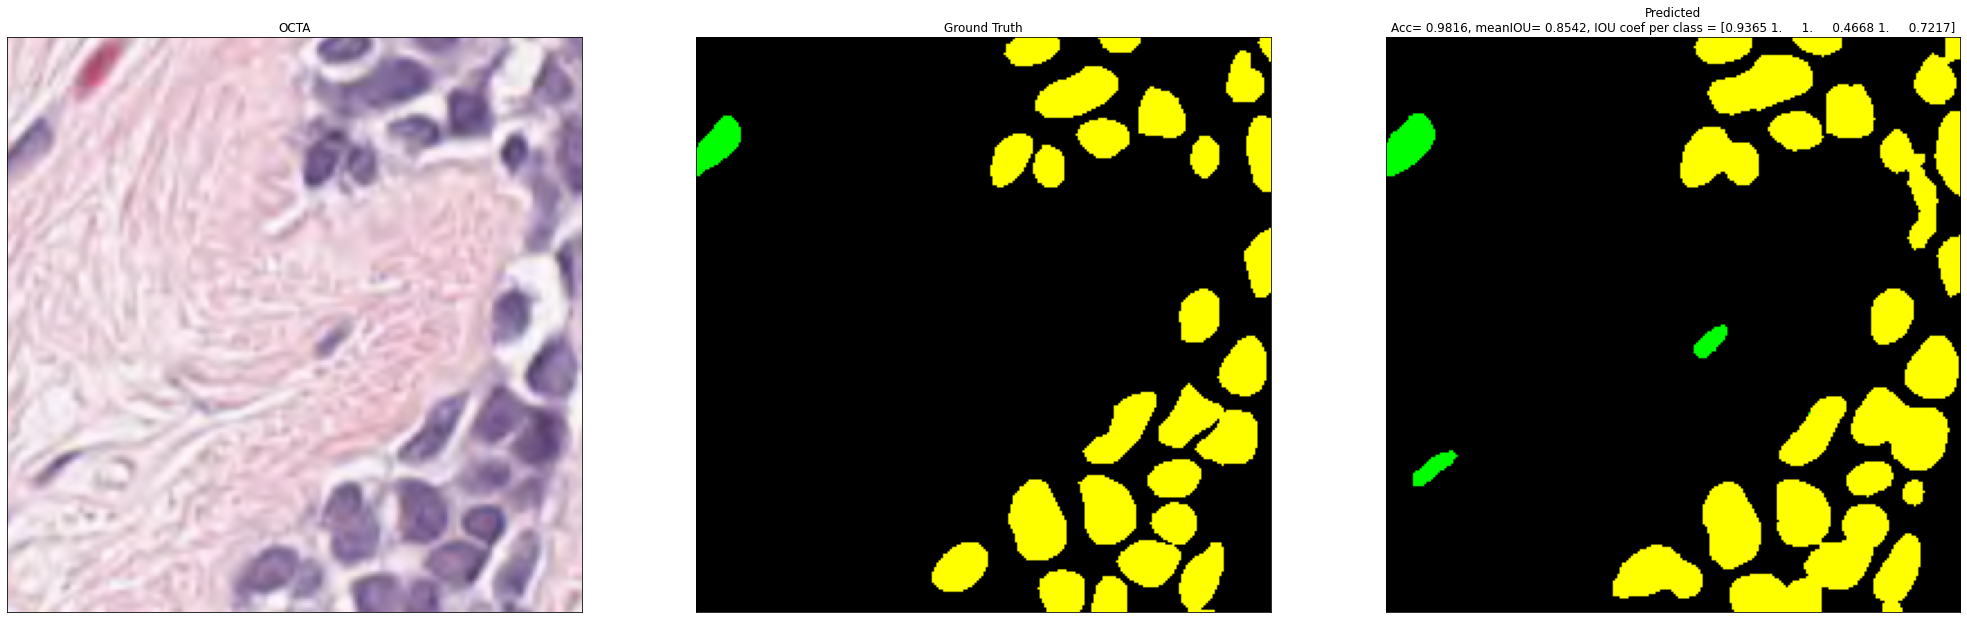

In [ ]:
# Sample fron training dataset
image_sample_number = random.sample(range(train_images.shape[0]), 1)[0]


impred = make_predictions(train_images[image_sample_number], train_masks[image_sample_number])

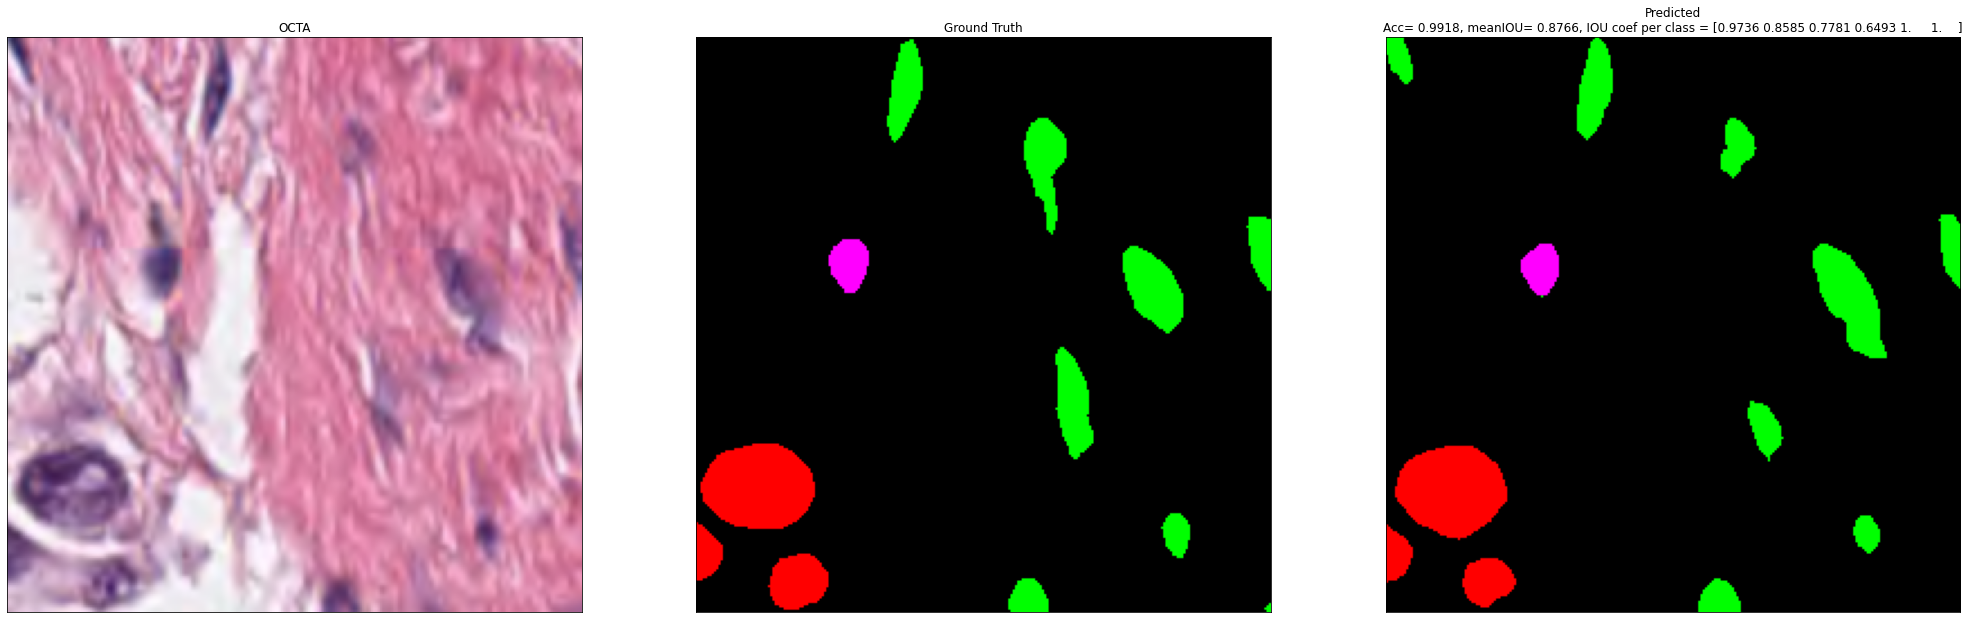

In [ ]:
# Sample fron validation dataset
image_sample_number = random.sample(range(valid_images.shape[0]), 1)[0]

impred = make_predictions(valid_images[image_sample_number], valid_masks[image_sample_number])